### Deep Convolutional Generative Adversarial Networks

Architecture guidelines for stable Deep Convolutional GANs
- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator). 
- Usebatchnorm in both the generator and the discriminator. 
- Remove fully connected hidden layers for deeper architectures. 
- UseReLUactivation in generator for all layers except for the output, which uses Tanh. 
- UseLeakyReLU activation in the discriminator for all layers.

In [9]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets
from torchvision.transforms import transforms

import pytorch_lightning as pl
torch.set_float32_matmul_precision('high')

In [10]:
from dotenv import load_dotenv
import os

DATASET_PATH = os.environ.get('DATASET_PATH',"./data")
BATCH_SIZE = 512 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

In [11]:
class MnistDataLoader(pl.LightningDataModule):
    def __init__(self,root,batch_size,num_workers):
        super(MnistDataLoader,self).__init__()
        self.root = root
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307),(0.3081))
        ])
        
        
    def prepare_data(self):
        datasets.MNIST(root = self.root,train=True,download=True)
        datasets.MNIST(root = self.root,train=False,download=True)

    def setup(self, stage):
        if stage == "fit" or stage is None:
            train_dataset = datasets.MNIST(root = self.root,train=True,download=False,transform = self.transform)
            
            # Define the proportions for the split
            train_proportion = 0.8  # 80% for training
            val_proportion = 0.2  # 20% for validation
    
            # Calculate the sizes of training and validation sets based on the proportions
            train_size = int(train_proportion * len(train_dataset))
            val_size = len(train_dataset) - train_size
            
            # Use random_split to split the dataset
            self.train_dataset, self.val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
        if stage == "test" or stage is None:
            self.test_dataset =  datasets.MNIST(root = self.root,train=False,download=False,transform = self.transform)
            

    def train_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self.train_dataset,batch_size=self.batch_size,shuffle=True,num_workers=self.num_workers,pin_memory=True)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self.val_dataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers,pin_memory=True)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self.test_dataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers,pin_memory=True)
   

In [12]:
ds = MnistDataLoader(DATASET_PATH,BATCH_SIZE,NUM_WORKERS)

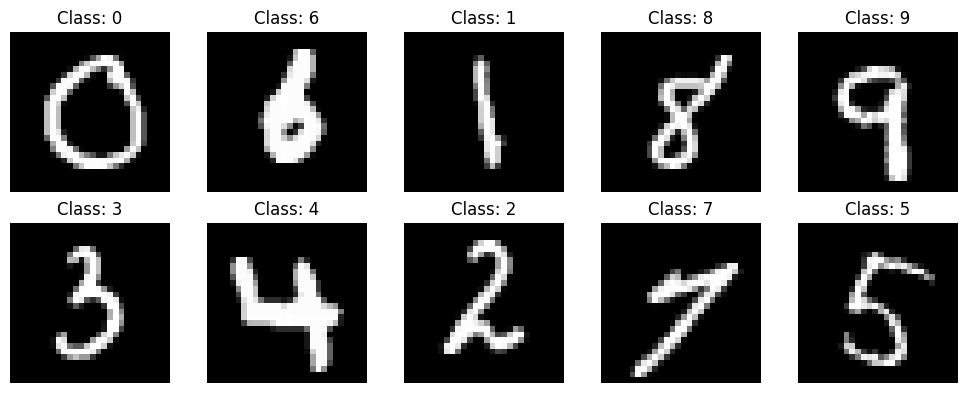

In [13]:
import matplotlib.pyplot as plt

# Sanity Check
ds.prepare_data()
ds.setup('fit')
dataloader = ds.train_dataloader()


# Create a dictionary to store one image per class
class_images = {}

# Iterate over the dataset and store one image per class
for image, label in ds.train_dataset:
    if label not in class_images:
        class_images[label] = image
        if len(class_images) == 10:  # Stop after storing one image per class
            break

# Display the images from each class
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, (label, image) in enumerate(class_images.items()):
    ax = axes[i // 5, i % 5]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f"Class: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

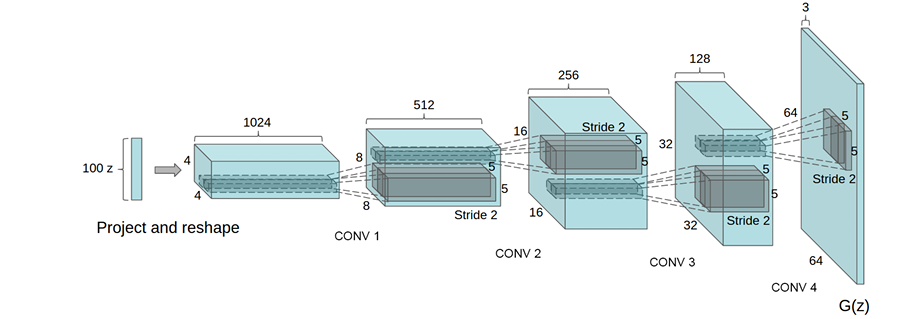

In [123]:
class Generator(nn.Module):
    def __init__(self,latent_dim,ngf,nc):
        super().__init__()
        self.g_model = nn.Sequential(*self._block(latent_dim,ngf*16,4,1,0), # N,1024,4,4
                                *self._block(ngf*16,ngf*8,4,2,1), 
                                *self._block(ngf*8,ngf*4,4,2,1), 
                                # *self._block(ngf*4,ngf*2,4,2,1), 
                                nn.ConvTranspose2d(ngf*4,nc,2,2,2,bias=False),
                                nn.Tanh())
                                
        

    def _block(self,in_channels,out_channels,kernal_size,stride,padding):
        return nn.Sequential(nn.ConvTranspose2d(in_channels,out_channels,kernal_size,stride,padding,bias=False),
                             nn.BatchNorm2d(out_channels),
                             nn.ReLU(inplace=True))

    def forward(self,x):
            # Input : N ,latent_dim, 1,1
            print("SHape",x.shape)
            return self.g_model(x)
    

In [131]:
class Discriminator(nn.Module):
    def __init__(self,nc,ndf):
        super().__init__()
        self.d_model =  nn.Sequential(nn.Conv2d(nc,ndf,2,1,1,bias=False),
                                     nn.LeakyReLU(0.2),
                                     *self._block(ndf,ndf*2,4,2,1),
                                     *self._block(ndf*2,ndf*4,4,2,1),
                                     *self._block(ndf*4,ndf*8,4,2,1),
                                     nn.Conv2d(ndf*8,1,4,1,0,bias=False),
                                     nn.Sigmoid()
                                     )

    def _block(self,in_channels,out_channels,kernal_size,stride,padding):
        return nn.Sequential(nn.Conv2d(in_channels,out_channels,kernal_size,stride,padding,bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.LeakyReLU(0.2,inplace=True))

    def forward(self,x):
        return self.d_model(x)
        

In [132]:
model

Discriminator(
  (d_model): Sequential(
    (0): Conv2d(1, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(28, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(56, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(112, 224, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(224, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [133]:
model = Generator(100,28,1)
# Define the hook function
def print_output_shape(module, input, output):
    print(f'{module.__class__.__name__} - Output Shape: {output.shape}')

# Register hooks for all Conv2d and ConvTranspose2d layers
for name, module in model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
        module.register_forward_hook(print_output_shape)

model(torch.randn(3,100,1,1)).shape

SHape torch.Size([3, 100, 1, 1])
ConvTranspose2d - Output Shape: torch.Size([3, 448, 4, 4])
ConvTranspose2d - Output Shape: torch.Size([3, 224, 8, 8])
ConvTranspose2d - Output Shape: torch.Size([3, 112, 16, 16])
ConvTranspose2d - Output Shape: torch.Size([3, 1, 28, 28])


torch.Size([3, 1, 28, 28])

In [134]:
model = Discriminator(1,28)
model(torch.rand(3,1,28,28))


RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (4 x 4). Kernel size can't be greater than actual input size

In [75]:
class GAN(pl.LightningModule):
    def __init__(self,latent_dim,nc,ngf,ndf,lr,b1,b2):
        super().__init__()

        self.save_hyperparameters()

        self.generator = Generator(latent_dim, ngf, nc)
        self.discriminator = Discriminator(nc, ndf)

        self.automatic_optimization = False

    def forward(self,z):
        return self.generator(z)

    def adversarial_loss(self,y_hat,y):
        return nn.functional.binary_cross_entropy(y_hat,y)

    def training_step(self,batch,batch_idx):
        imgs, _ = batch 

        # sample noise 
        z = torch.randn(imgs.shape[0],self.hparams.latent_dim).type_as(imgs)


        # ground truth 
        label_one = torch.ones(imgs.shape[0],1).type_as(imgs)
        label_zero = torch.zeros(imgs.shape[0],1).type_as(imgs)

        # Get optimizers
        g_opt, d_opt = self.optimizers()

        # Train Generator
        self.toggle_optimizer(g_opt)

        self.generated_img = self(z)

        #log 
        if not batch_idx % 100:
            sample_imgs = self.generated_img[:6]
            grid = torchvision.utils.make_grid(sample_imgs.view(-1,1,28,28))
            self.logger.experiment.add_image('generated_images',grid,self.current_epoch)
        
        g_loss = self.adversarial_loss(self.discriminator(self.generated_img),label_one)
        self.log('g_loss',g_loss,prog_bar=True)

        self.manual_backward(g_loss)
        g_opt.step()
        g_opt.zero_grad()
        self.untoggle_optimizer(g_opt)


        # Train discriminator
        self.toggle_optimizer(d_opt)
        # how well it can be label as real
        real_loss = self.adversarial_loss(self.discriminator(imgs.view(imgs.shape[0],-1)),label_one)
        # how well it can be label as fake
        fake_loss = self.adversarial_loss(self.discriminator(self.generated_img.detach()),label_zero)

        d_loss = (real_loss + fake_loss)/2
        self.log('d_loss',d_loss,prog_bar=True)

        self.manual_backward(d_loss)
        d_opt.step()
        d_opt.zero_grad()
        self.untoggle_optimizer(d_loss)


    def validation_step(self,batch):
        imgs, _ = batch
        validation_noise = torch.randn(8,self.hparams.latent_dim).type_as(imgs)
                    
        #log 
        sample_imgs = self(validation_noise)
        grid = torchvision.utils.make_grid(sample_imgs.view(-1,1,28,28))
        self.logger.experiment.add_image('Validation_z',grid,self.current_epoch)
        

    def configure_optimizers(self):
        g_opt = torch.optim.AdamW(self.generator.parameters(),lr=self.hparams.lr, betas=[self.hparams.b1,self.hparams.b2])
        d_opt = torch.optim.AdamW(self.discriminator.parameters(),lr=self.hparams.lr, betas=[self.hparams.b1,self.hparams.b2])            
            
        return [g_opt,d_opt], []
    

In [ ]:
ngf = 28
ndf = 28
nc = 3
latent_dim = 50


